In [1]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 as transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import os
import cv2

/opt/homebrew/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/homebrew/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: h

In [2]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
BASE_DIR = "../../data/broad_dataset/"

In [4]:
class BroadDataset(Dataset):
    """
    https://bbbc.broadinstitute.org/BBBC038
    """
    def __init__(self, train_images_dir, transform = None):
        super().__init__()
        self.train_images_dir = train_images_dir
        self.transform = transform
        self.image_dirs = os.listdir(train_images_dir)
        self.fn_idx_map = {}
        for idx, fn in enumerate(self.image_dirs):
            self.fn_idx_map[idx] = fn

    def __len__(self) -> int:
        return len(self.image_dirs)

    def combine_masks(self, masks_dir: str, target_shape: tuple[int]) -> np.ndarray:
        combined_mask = np.zeros(target_shape, dtype=np.uint8)
        for mask_file in os.listdir(masks_dir):
            mask = cv2.imread(os.path.join(masks_dir, mask_file))

            combined_mask = np.maximum(combined_mask, mask)

        return combined_mask

    def __getitem__(self, index: int) -> tuple[np.ndarray, np.ndarray]:
        size = self.__len__()
        if index < 0 or index >= size:
            raise ValueError(f"Invalid Index: index should be >= 0 and less than size of dataset: {size}")
        fn = self.fn_idx_map[index]
        index_dir = os.path.join(self.train_images_dir, fn)

        images_dir = os.path.join(index_dir, "images")
        masks_dir = os.path.join(index_dir, "masks")

        image_filename = os.listdir(images_dir)[0]

        image = cv2.imread(os.path.join(images_dir, image_filename))
        mask = self.combine_masks(masks_dir, image.shape)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [5]:
train_images = os.path.join(BASE_DIR, "stage1_train")

### show images before transforms

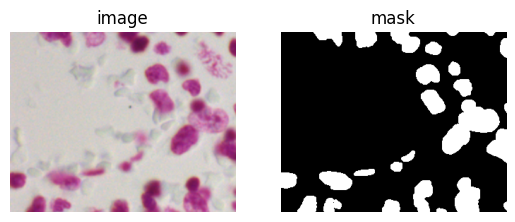

In [22]:
training_data = BroadDataset(train_images)
image, mask = training_data[4]

f, ax = plt.subplots(ncols=2)
ax[0].imshow(image)
ax[0].set_title("image")
ax[0].axis("off")
ax[1].imshow(mask)
ax[1].set_title("mask")
ax[1].axis("off")


plt.show()

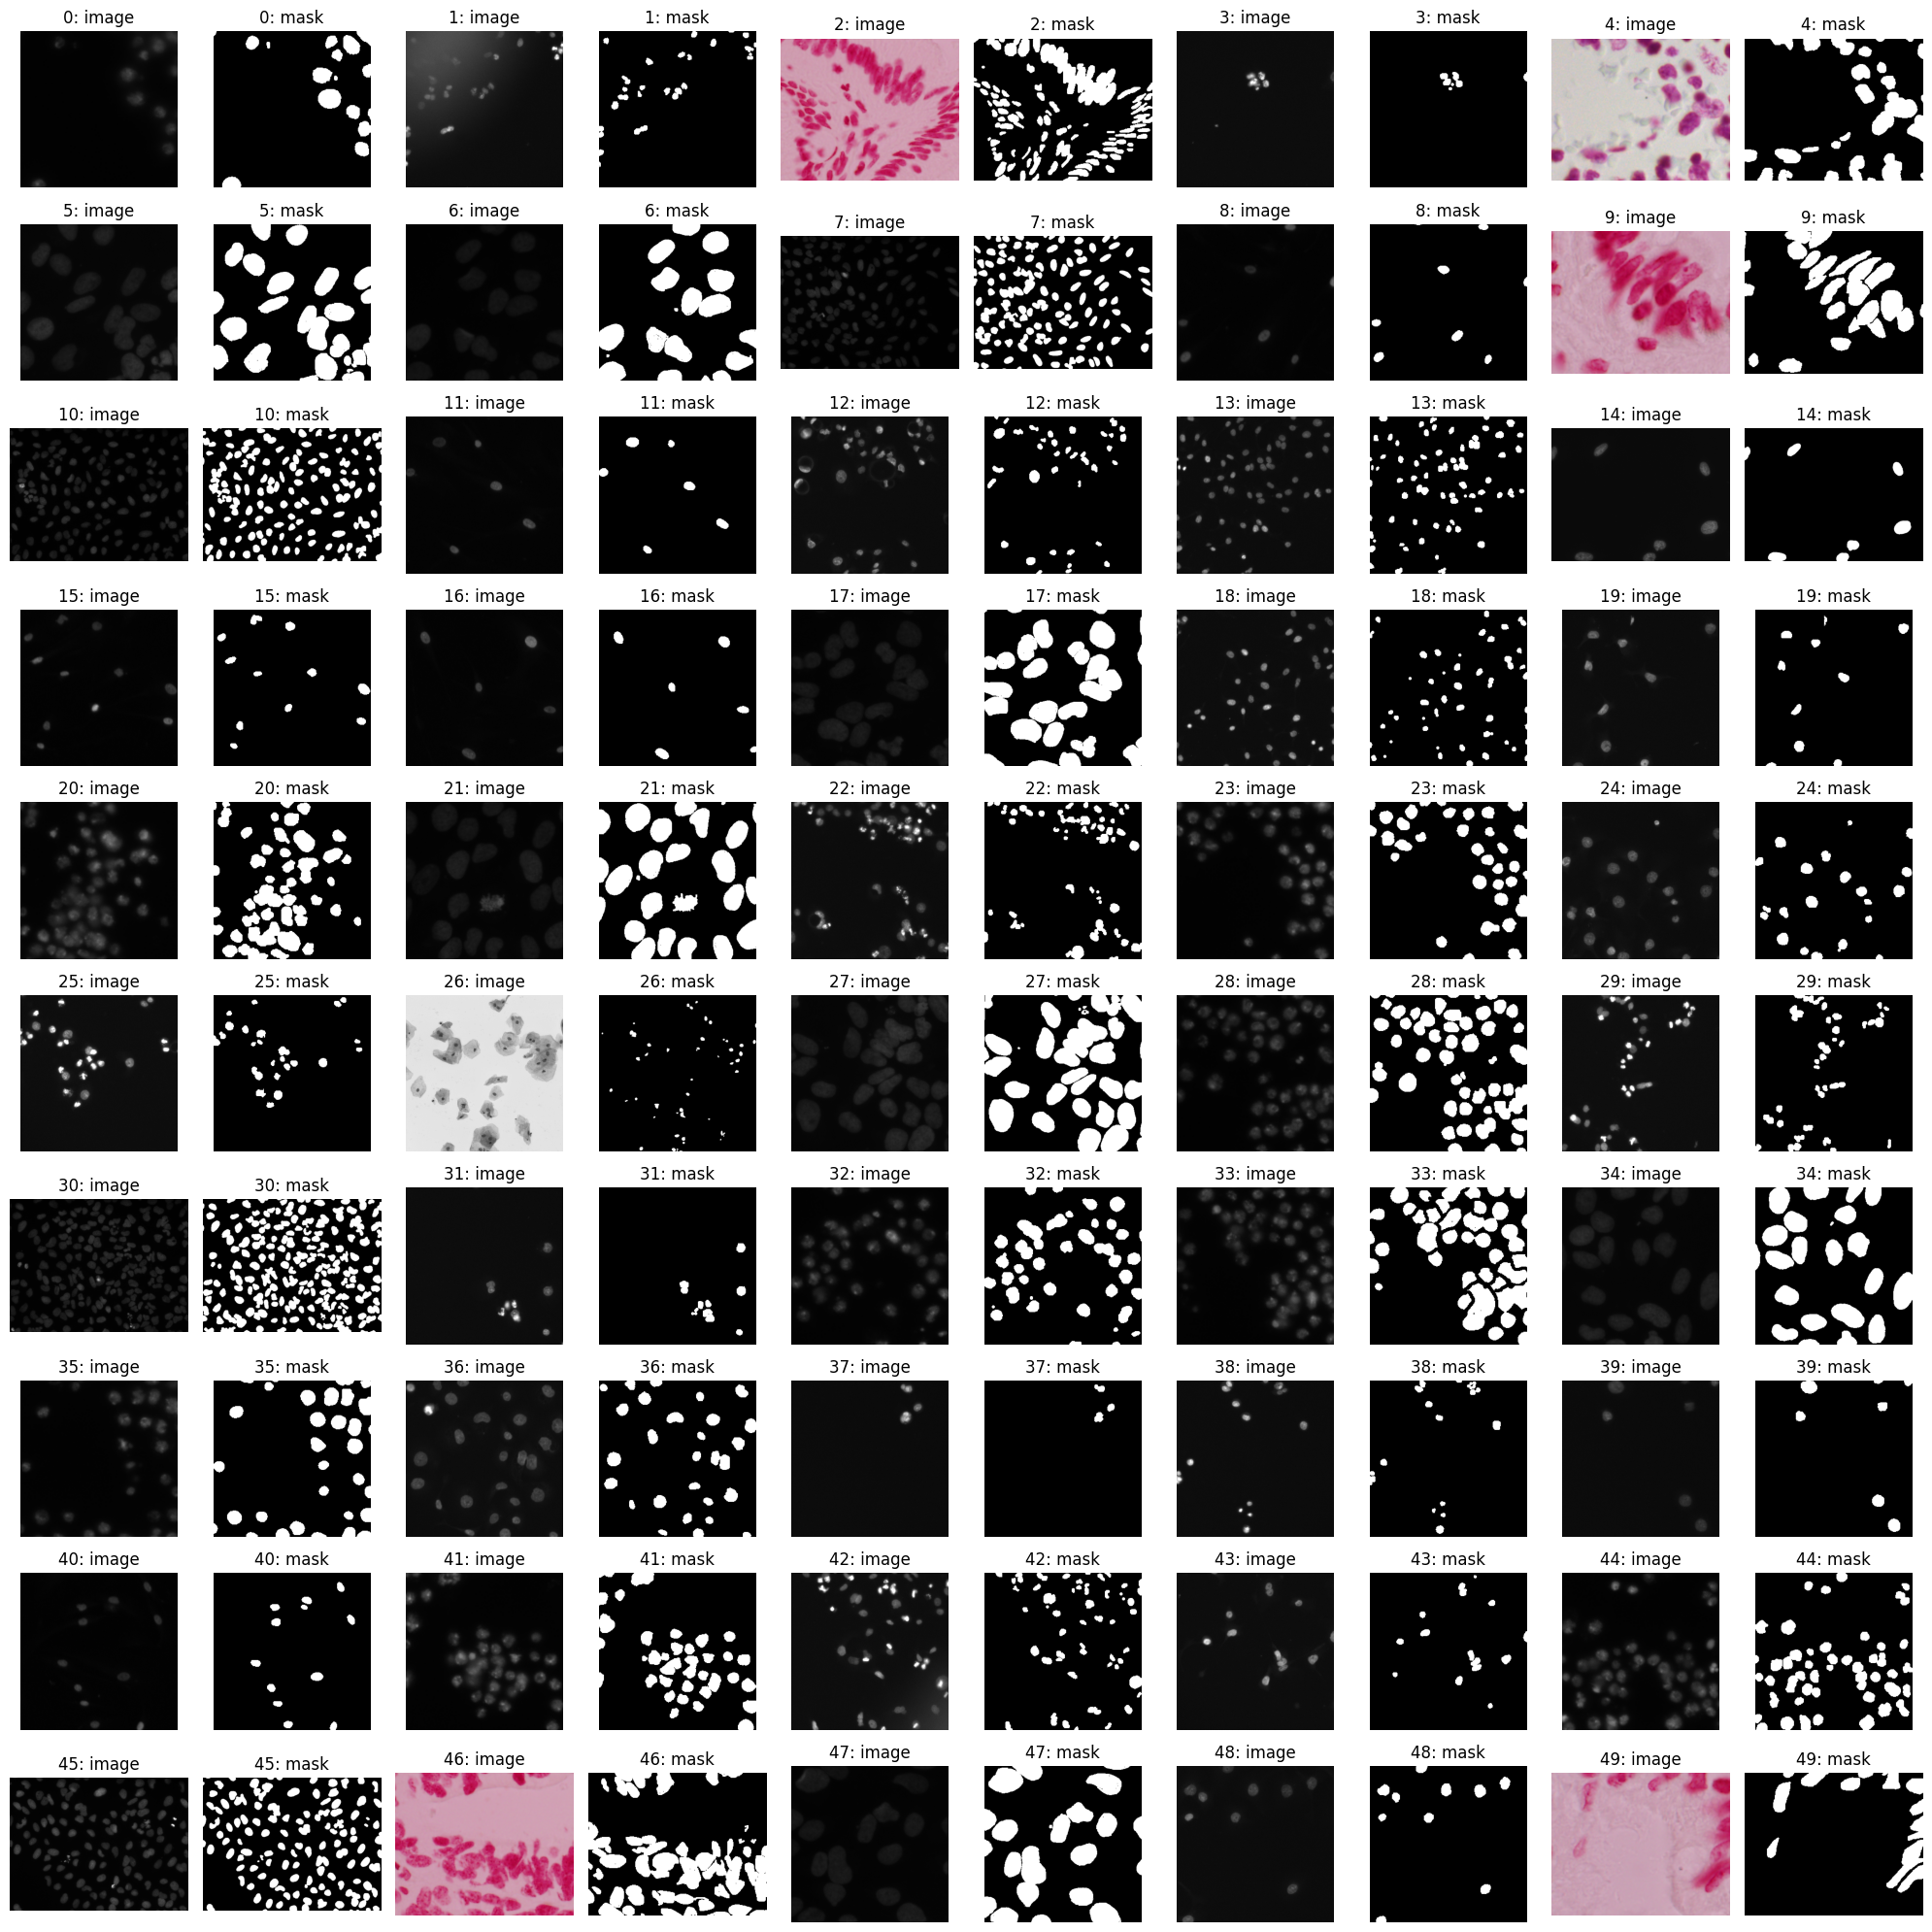

In [7]:
n_rows, n_cols = 10, 5
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols * 2, figsize=(20, 20))

for i in range(n_rows):
    for j in range(n_cols):
        idx = i * n_cols + j
        if idx < 50:
            # display image
            ax_img = axes[i, j * 2]
            ax_img.imshow(training_data[idx][0])
            ax_img.set_title(f"{idx}: image")
            ax_img.axis("off")

            # display mask
            ax_img = axes[i, j * 2 + 1]
            ax_img.imshow(training_data[idx][1])
            ax_img.set_title(f"{idx}: mask")
            ax_img.axis("off")

plt.tight_layout()
plt.show()


### run transforms and load dataset again

In [8]:
common_size = (256, 256)

transform = transforms.Compose([
    transforms.ToImageTensor(),
    transforms.ToDtype(torch.uint8),
    transforms.Resize(common_size, antialias=True),
])

In [9]:
training_data = BroadDataset(train_images, transform=transform)

In [10]:
len(training_data)

670

In [11]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)

### Iterate through dataloader

In [12]:
train_image, train_mask = next(iter(train_dataloader))
print(f"Feature batch shape: {train_image.shape}")
print(f"Masks batch shape: {train_mask.shape}")

Feature batch shape: torch.Size([64, 3, 256, 256])
Masks batch shape: torch.Size([64, 3, 256, 256])


In [13]:
img = train_image[0]  # pick first image in batch
img = img.squeeze()
img.shape

torch.Size([3, 256, 256])

In [14]:
mask = train_mask[0]
mask.shape

torch.Size([3, 256, 256])

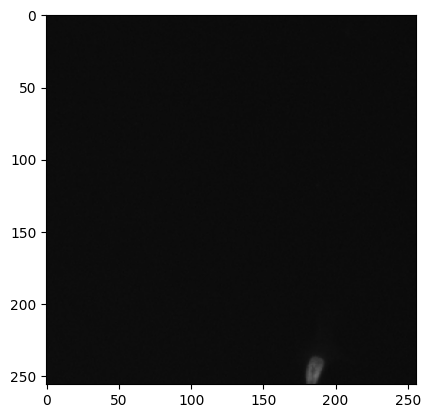

In [15]:
if img.shape[0] == 3:
    img = img.permute(1, 2, 0)
plt.imshow(img)
plt.show()

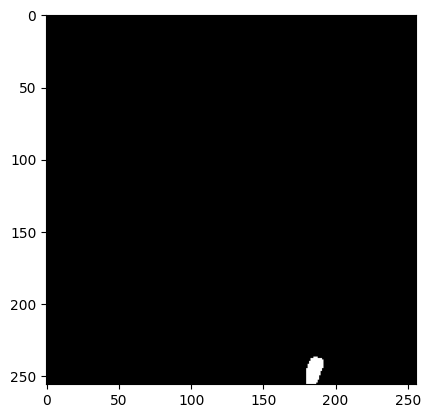

In [16]:
if mask.shape[0] == 3:
    mask = mask.permute(1, 2, 0)
plt.imshow(mask)
plt.show()